In [73]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

from load_data import LoadData

In [74]:
data_location = '../Sample Data/'
export_date = '2025-03-01'
load_data = LoadData(data_location, export_date)

### Response variables

In [75]:
mood_data = load_data.load_mood_data()
mood_data.head()

,dt,mood_type,value,updated_time
0,"Sat, 6 May 2023 14:00:58",feeling,4,"Sat, 6 May 2023 14:00:58"
1,"Sun, 11 Feb 2024 04:06:37",satisfaction,4,"Sun, 11 Feb 2024 04:06:37"
2,"Wed, 2 Nov 2022 09:04:11",motivation,3,"Wed, 2 Nov 2022 09:04:11"
3,"Wed, 12 Jul 2023 19:02:37",feeling,3,"Wed, 12 Jul 2023 19:02:37"
4,"Sat, 1 Mar 2025 13:39:47",motivation,2,"Sat, 1 Mar 2025 13:39:47"


In [76]:
mood_data['value'] = pd.to_numeric(mood_data.value)

In [77]:
# note: a pandas update didn't like the non-zero-padded 'day' of the Finch data
# so I'm using datetime.strptime instead of pd.to_datetime for now
mood_data['Record_Datetime'] = mood_data.dt.map(lambda x: datetime.strptime(x, "%a, %d %b %Y %H:%M:%S"))
mood_data = mood_data.drop(['dt','updated_time'],axis=1)

In [78]:
mood_data.head()

,mood_type,value,Record_Datetime
0,feeling,4,2023-05-06 14:00:58
1,satisfaction,4,2024-02-11 04:06:37
2,motivation,3,2022-11-02 09:04:11
3,feeling,3,2023-07-12 19:02:37
4,motivation,2,2025-03-01 13:39:47


In [79]:
# subtract 7 hrs from datetime
# 7 is good because at 7am the next day starts ( according to my Finch app settings ),
# so the satisfaction score of the previous day must be submitted by then
MORNING_CUTOFF_HOUR = 7
time_shift = timedelta(hours=MORNING_CUTOFF_HOUR)

In [80]:
mood_data['Adjusted_Datetime'] = mood_data['Record_Datetime'] - time_shift
mood_data['Record_Date'] = mood_data['Adjusted_Datetime'].dt.date

In [81]:
#find date range to use
# here I cut off the last day because usually the export date isn't a completed day
start_date = mood_data['Record_Date'].min()
end_date = mood_data['Record_Date'].max() - timedelta(days=1)

In [82]:
all_days = pd.date_range(start=start_date, end=end_date, freq='D')

In [83]:
dfs = {}
for mood_type in ('feeling','satisfaction','motivation'):
    type_df = mood_data[mood_data['mood_type'] == mood_type].copy()
    
    if mood_type == 'feeling':
        type_df = type_df.groupby('Record_Date')['value'].mean()
    else:
        # ugh these should only have 1 value a day, shouldn't do first!
        # TODO
        type_df = type_df.groupby('Record_Date')['value'].first() 
    
    # Reindex to full range
    type_df = type_df.reindex(all_days)
    type_df.name = mood_type
    dfs[mood_type] = type_df

In [84]:
# Combine into one DataFrame
mood_df = pd.concat(dfs.values(), axis=1)
mood_df.index.name = 'Record_Date'
mood_df = mood_df.reset_index()
mood_df = mood_df.rename(columns={'feeling':'average_feeling'})


In [85]:
mood_df.head()

,Record_Date,average_feeling,satisfaction,motivation
0,2022-10-26,3.000000,3.0,3.0
1,2022-10-27,2.833333,2.0,4.0
2,2022-10-28,3.125000,4.0,2.0
3,2022-10-29,3.375000,3.0,3.0
4,2022-10-30,3.571429,4.0,4.0


### Feelings

In [86]:
avg_feelings_df = mood_df[['Record_Date','average_feeling']]
avg_feelings_df = avg_feelings_df.rename(columns={'average_feeling':'value'})
avg_feelings_df.head()

,Record_Date,value
0,2022-10-26,3.000000
1,2022-10-27,2.833333
2,2022-10-28,3.125000
3,2022-10-29,3.375000
4,2022-10-30,3.571429


### Explanatory variables

In [87]:
exvar_data = load_data.load_activity_data()
exvar_data.head()

,dt,bullet_type,text,score,is_processed,bullet_status,preferred_emoji_char,completed_time,creation_time,position,...,linked_action_config.bullet.targeting_power_up_uuids,linked_action_config.bullet.associated_power_up_uuids,linked_action_config.bullet.linked_action_config,preferred_area_names,action_name,story_id,is_persistent,preferred_sentiment,gift_ids,linked_community_habit_id
0,"Sun, 28 Apr 2024 01:00:00",1,#Meditation Timer,0.000000,True,0.0,🧘🏾,,"Sun, 28 Apr 2024 08:50:29",7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Thu, 11 Apr 2024 01:00:00",1,Think about a positive moment with #yoga,6.666667,True,0.0,NaN,,"Thu, 11 Apr 2024 09:01:23",0.0,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Fri, 17 May 2024 01:00:00",1,#Yoga,0.000000,True,0.0,NaN,,"Fri, 17 May 2024 10:26:16",3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Sun, 28 Jan 2024 01:00:00",1,Think about a positive moment with #yoga,6.666667,True,0.0,NaN,,"Sun, 28 Jan 2024 07:45:41",0.0,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Tue, 5 Sep 2023 01:00:00",1,#Read for #fun,6.666667,True,1.0,NaN,"Tue, 5 Sep 2023 14:56:34","Tue, 5 Sep 2023 10:16:36",8.0,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
exvar_df = exvar_data[['dt','bullet_type','text','bullet_status']]
exvar_df = exvar_df.query("bullet_type == 1")
exvar_df = exvar_df.drop('bullet_type',axis=1)

In [89]:
exvar_df.head()

,dt,text,bullet_status
0,"Sun, 28 Apr 2024 01:00:00",#Meditation Timer,0.0
1,"Thu, 11 Apr 2024 01:00:00",Think about a positive moment with #yoga,0.0
2,"Fri, 17 May 2024 01:00:00",#Yoga,0.0
3,"Sun, 28 Jan 2024 01:00:00",Think about a positive moment with #yoga,0.0
4,"Tue, 5 Sep 2023 01:00:00",#Read for #fun,1.0


In [90]:
# convert to datetime
exvar_df['Record_Date'] = exvar_df.dt.map(lambda x: datetime.strptime(x, "%a, %d %b %Y %H:%M:%S")).dt.date
exvar_df = exvar_df.drop(['dt'],axis=1)

In [91]:
exvar_df.head()

,text,bullet_status,Record_Date
0,#Meditation Timer,0.0,2024-04-28
1,Think about a positive moment with #yoga,0.0,2024-04-11
2,#Yoga,0.0,2024-05-17
3,Think about a positive moment with #yoga,0.0,2024-01-28
4,#Read for #fun,1.0,2023-09-05


In [92]:
exvar_df['text'] = exvar_df['text'].str.replace("#","")
exvar_df.groupby('text').count().sort_values('bullet_status',ascending=False).head()

,bullet_status,Record_Date
text,,
Drink water,853,853
Put away one item that is not in its place,852,852
7000 steps,850,850
Meditation Timer,847,847
Just be,839,839


In [93]:
# replace {old_name: new name}
duplicates_dict = {
    "Laundry":"Start a load of laundry",
    "Create a Finch_Backup_File":"Create a Finch Backup File",
    "Walk around the neighborhood":"Mindfulness Walk",
    "Make a gratitude list before sleeping":"Gratitude Jar",
    "Reflect on how friends makes me feel gratitude lately":"Gratitude Jar",
    "One Job Hunting task":"Do 1 Job Hunt Related Task",
    "Express gratitude to a friend I'm thankful for":"Gratitude Jar"
}

In [94]:
exvar_df['text'] = exvar_df['text'].replace(duplicates_dict)

In [95]:
exvar_df.head()

,text,bullet_status,Record_Date
0,Meditation Timer,0.0,2024-04-28
1,Think about a positive moment with yoga,0.0,2024-04-11
2,Yoga,0.0,2024-05-17
3,Think about a positive moment with yoga,0.0,2024-01-28
4,Read for fun,1.0,2023-09-05


In [96]:
exvar_df = exvar_df.sort_values('Record_Date',ascending=False)
exvar_df.head()

,text,bullet_status,Record_Date
10684,Apply to 1 Job,0.0,2025-03-01
5820,Think about a positive moment with yoga,0.0,2025-03-01
6729,Remind myself of the challenges I've overcome ...,0.0,2025-03-01
13418,Create a dedicated workspace to draw better bo...,0.0,2025-03-01
11989,Just be,1.0,2025-03-01


In [97]:
completed_variables_df = exvar_df.query("bullet_status == 1.0").drop(['bullet_status'],axis=1)
completed_variables_df = completed_variables_df.rename(columns={'text':'variable'})
completed_variables_df.head()

,variable,Record_Date
11989,Just be,2025-03-01
5652,Eat breakfast,2025-03-01
7609,Read for fun,2025-03-01
2804,Take meds,2025-03-01
10732,Take Vitamin_D,2025-03-01


In [98]:
completed_variables_df.shape

(6817, 2)

In [99]:
# try smaller amount of variables for now, using the most commonly completed (which could be an issue?)
num_variables = 20
top_ex_variables = completed_variables_df.groupby('variable').count().sort_values('Record_Date', ascending=False).head(num_variables).index.to_list()

In [100]:
top_ex_variables

['Drink water',
 'Just be',
 'Put away one item that is not in its place',
 'Eat breakfast',
 'Eat lunch',
 'Eat Dinner',
 'Meditation Timer',
 'Mindfulness Walk',
 'Read for fun',
 '7000 steps',
 'Take a shower',
 'Step outside once',
 'Yoga',
 'Take meds',
 'Start a load of laundry',
 'Take Vitamin_D',
 'Do 1 Job Hunt Related Task',
 'Gratitude Jar',
 'Take Vitamin_C',
 'Make art 🎨']

In [101]:
# choose from these top 20 the activities that I suspect have a big influence on my mood
ex_variables = [
    'Eat breakfast',
    'Eat lunch',
    'Eat Dinner',
    'Meditation Timer',
    'Mindfulness Walk',
    'Read for fun',
    '7000 steps',
    'Take a shower',
    'Step outside once',
    'Yoga',
    'Gratitude Jar',
]

In [102]:
# clean variables/column names a bit
ex_var_dict = {}
for var in ex_variables:
    ex_var_dict[var] = string.capwords(var)

In [103]:
completed_var_limit_df = completed_variables_df[completed_variables_df['variable'].isin(ex_variables)]
completed_encoded_exvar_df = pd.get_dummies(completed_var_limit_df.variable).join(completed_var_limit_df).drop('variable',axis=1)
completed_encoded_exvar_df = completed_encoded_exvar_df.rename(columns=ex_var_dict)
completed_encoded_exvar_df.head()

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation Timer,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga,Record_Date
5652,False,False,True,False,False,False,False,False,False,False,False,2025-03-01
7609,False,False,False,False,False,False,False,True,False,False,False,2025-03-01
2582,False,False,True,False,False,False,False,False,False,False,False,2025-02-28
12651,False,False,False,False,False,False,False,False,True,False,False,2025-02-28
5454,False,False,False,True,False,False,False,False,False,False,False,2025-02-28


In [104]:
exvar_encoded_df = completed_encoded_exvar_df.groupby('Record_Date').any()
exvar_encoded_df.head()

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation Timer,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga
Record_Date,,,,,,,,,,,
2022-10-27,False,False,False,False,True,False,False,False,False,False,False
2022-10-31,True,False,False,False,False,False,False,False,False,False,False
2022-11-01,True,False,False,False,False,True,False,False,False,False,False
2022-11-02,False,False,False,False,False,True,False,False,False,False,False
2022-11-03,True,False,False,False,False,True,False,False,False,False,False


### Meditation vs Mood

In [105]:
exvar_encoded_df = exvar_encoded_df.sort_values('Record_Date')
exvar_encoded_df.head()

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation Timer,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga
Record_Date,,,,,,,,,,,
2022-10-27,False,False,False,False,True,False,False,False,False,False,False
2022-10-31,True,False,False,False,False,False,False,False,False,False,False
2022-11-01,True,False,False,False,False,True,False,False,False,False,False
2022-11-02,False,False,False,False,False,True,False,False,False,False,False
2022-11-03,True,False,False,False,False,True,False,False,False,False,False


In [106]:
all_days = pd.date_range(start=exvar_encoded_df.index.min(), end=exvar_encoded_df.index.max(), freq='D')

In [107]:
exvar_encoded_df = exvar_encoded_df.reindex(all_days)

In [108]:
exvar_encoded_df.head()

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation Timer,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga
2022-10-27,False,False,False,False,True,False,False,False,False,False,False
2022-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,True,False,False,False,False,False,False,False,False,False,False


In [109]:
avg_feelings_df = avg_feelings_df.set_index('Record_Date')

In [110]:
feeling_min_date = avg_feelings_df.index.min()
feeling_max_date = avg_feelings_df.index.max()

In [111]:
exvar_min_date = exvar_encoded_df.index.min()
exvar_max_date = exvar_encoded_df.index.max()

In [112]:
min_date = max(feeling_min_date,exvar_min_date)
max_date = min(feeling_max_date,exvar_max_date)

In [113]:
avg_feelings_df = avg_feelings_df[(avg_feelings_df.index > min_date) & (avg_feelings_df.index < max_date)]
exvar_encoded_df = exvar_encoded_df[(exvar_encoded_df.index > min_date) & (exvar_encoded_df.index < max_date)]

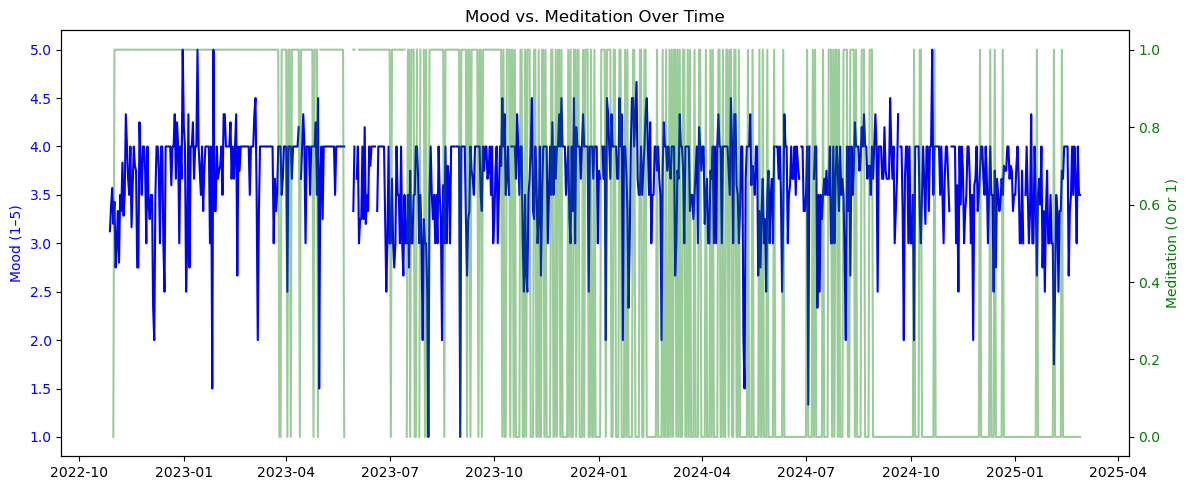

In [114]:
# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Mood
ax1.plot(avg_feelings_df.index, avg_feelings_df['value'], label='Mood (7-day Avg)', color='blue')
ax1.set_ylabel('Mood (1–5)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Meditation (right axis)
ax2 = ax1.twinx()
ax2.plot(exvar_encoded_df.index, exvar_encoded_df['Meditation Timer'], label='Meditation', color='green', alpha=0.4)
ax2.set_ylabel('Meditation (0 or 1)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Mood vs. Meditation Over Time')
fig.tight_layout()
plt.show()


### Linear Regression Analysis

In [115]:
features = exvar_encoded_df.columns.to_list()

In [116]:
for col in features:
    exvar_encoded_df[col] = pd.to_numeric(exvar_encoded_df[col], errors='coerce')
exvar_encoded_df.head()    

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation Timer,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga
2022-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [117]:
# introducing 1 day lag, i.e. do yesterday's self care activities influence today's mood?
lagged_1day_features = []
for col in features:
    col_name = f'{col}_lag1'
    exvar_encoded_df[col_name] = exvar_encoded_df[col].shift(1)
    lagged_1day_features.append(col_name)
lagged_1day_features

['7000 Steps_lag1',
 'Eat Dinner_lag1',
 'Eat Breakfast_lag1',
 'Eat Lunch_lag1',
 'Gratitude Jar_lag1',
 'Meditation Timer_lag1',
 'Mindfulness Walk_lag1',
 'Read For Fun_lag1',
 'Step Outside Once_lag1',
 'Take A Shower_lag1',
 'Yoga_lag1']

In [118]:
exvar_encoded_df.index.name = 'Record_Date'

In [119]:
df = pd.merge(avg_feelings_df.reset_index(), exvar_encoded_df[lagged_1day_features].reset_index(), on='Record_Date', how='inner')

In [120]:
df.head()

,Record_Date,value,7000 Steps_lag1,Eat Dinner_lag1,Eat Breakfast_lag1,Eat Lunch_lag1,Gratitude Jar_lag1,Meditation Timer_lag1,Mindfulness Walk_lag1,Read For Fun_lag1,Step Outside Once_lag1,Take A Shower_lag1,Yoga_lag1
0,2022-10-28,3.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-29,3.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-30,3.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-31,3.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-01,3.428571,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
fill_values = {}
for col in lagged_1day_features:
    fill_values[col] = 0
    
df = df.fillna(value=fill_values)
df = df.dropna(subset=['value'])
# assuming that if I'm missing records then I just didn't do that activity

In [122]:
df.head()

,Record_Date,value,7000 Steps_lag1,Eat Dinner_lag1,Eat Breakfast_lag1,Eat Lunch_lag1,Gratitude Jar_lag1,Meditation Timer_lag1,Mindfulness Walk_lag1,Read For Fun_lag1,Step Outside Once_lag1,Take A Shower_lag1,Yoga_lag1
0,2022-10-28,3.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-29,3.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-30,3.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-31,3.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-11-01,3.428571,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
X = df[lagged_1day_features]
y = df['value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [125]:
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R² Score: 0.030549264266997334
MSE: 0.2618797832394541


In [126]:
# Pair coefficients with feature names
coeff_df = pd.DataFrame({
    'Feature': lagged_1day_features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)
coeff_df

,Feature,Coefficient
1,Eat Dinner_lag1,0.107756
5,Meditation Timer_lag1,0.100189
8,Step Outside Once_lag1,0.088838
0,7000 Steps_lag1,0.041539
2,Eat Breakfast_lag1,0.012197
6,Mindfulness Walk_lag1,0.011438
4,Gratitude Jar_lag1,-0.027960
3,Eat Lunch_lag1,-0.034035
10,Yoga_lag1,-0.054734
9,Take A Shower_lag1,-0.085621


So feature Eat Dinner_lag1 has a coefficient of 0.107756
* I.E. Eating dinner yesterday had a positive but marginal effect on today's mood
* It doesn't sound huge, but if a few habits stack up positively (e.g., dinner, meditation, walk), they can have a compounding effect.

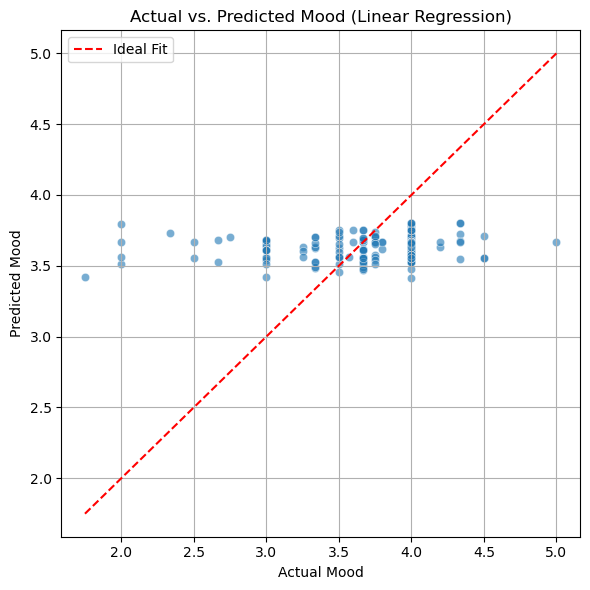

In [127]:
# examine predicted vs acuatal mood for this model

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Mood')
plt.ylabel('Predicted Mood')
plt.title('Actual vs. Predicted Mood (Linear Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [128]:
# Regression model, look at significance
X_with_const = sm.add_constant(X)  # adds intercept term, i.e. baseline mood when I didn’t do any of the activities that day
model = sm.OLS(y, X_with_const).fit()

In [129]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.147
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0154
Time:                        17:09:07   Log-Likelihood:                -644.82
No. Observations:                 833   AIC:                             1314.
Df Residuals:                     821   BIC:                             1370.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.5485      0.054     65.511      0.000       3.442       3.655
7000 Steps_lag1            0.0381      0.043      0.890      0.374      -0.046       0.122
Eat Dinner_lag1            0.0611      0.067      0.915      0.360      -0.070       0.192
Eat Breakfast_lag1         0.0269      0.078      0.344      0.731      -0.126       0.180
Eat Lunch_lag1            -0.0041      0.043     -0.096      0.924      -0.088       0.080
Gratitude Jar_lag1         0.0127      0.075      0.168      0.867      -0.135       0.161
Meditation Timer_lag1      0.1157      0.046      2.496      0.013       0.025       0.207
Mindfulness Walk_lag1      0.0489      0.060      0.810      0.418      -0.070       0.167
Read For Fun_lag1         -0.1018      0.057     -1.788      0.074      -0.213       0.010
Step Outside Once_lag1     0.1001      0.075      1.341      0.180      -0.046       0.247
Take A Shower_lag1        -0.0631      0.076     -0.834      0.404      -0.211       0.085
Yoga_lag1                 -0.0948      0.050     -1.889      0.059      -0.193       0.004
==============================================================================
Omnibus:                      233.852   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.043
Skew:                          -1.414   Prob(JB):                    3.14e-141
Kurtosis:                       6.263   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Meditation Timer_lag1 and Yoga_lag1 are the most significant features based on these p-values
* meditation makes sense, I would suspect meditation would lead to improved mood over time
* interestingly, yoga_lag1 coincides with a negative influence on mood! (not necesarrily *causing* the lower mood, could be other reasons the day-after-yoga mood is low)

In [130]:
# lets examine mood on day after yoga vs no yoga days
df_box = df[['value', 'Yoga_lag1']].dropna()

#map to labels for nicer x-axis
df_box['Yoga_Yesterday'] = df_box['Yoga_lag1'].map({0: 'No Yoga', 1: 'Yoga'})

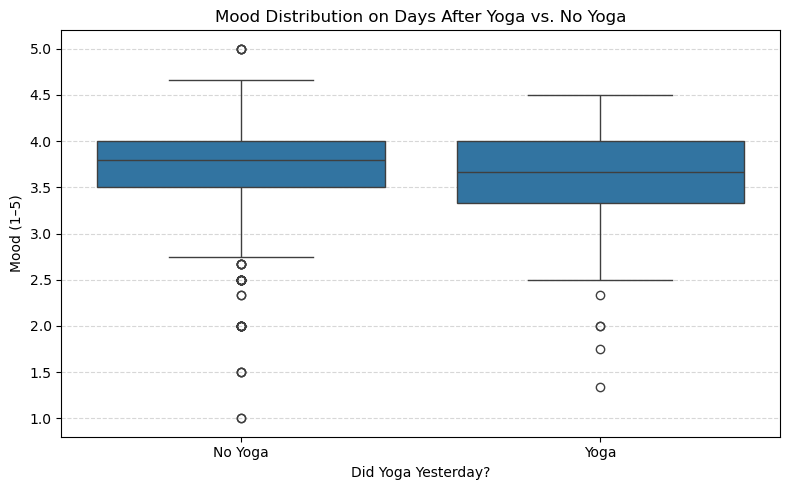

In [131]:
# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Yoga_Yesterday', y='value', data=df_box)
plt.title("Mood Distribution on Days After Yoga vs. No Yoga")
plt.ylabel("Mood (1–5)")
plt.xlabel("Did Yoga Yesterday?")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

thoughts:
* median mood is very similar for both groups (but aligns with the negative coefficient from the regression model)
* Days after "no yoga" have more variability and outliers, while days after "yoga" have a tighter IQR, suggesting that yoga could influence a more *stable* mood if not a higher one
* it could be helpful in the future to break yoga activity feature into 'restorative yoga' or 'power yoga'; as we know the day after a workout doesn't always feel the best, even if it's generally considered good for you!

### Random Forest Analysis

In [132]:
# Using same X_train, X_test, y_train, y_test as previous model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [133]:
importances = model_rf.feature_importances_

# Create a DataFrame for sorting and plotting
imp_df = pd.DataFrame({
    'Feature': lagged_1day_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

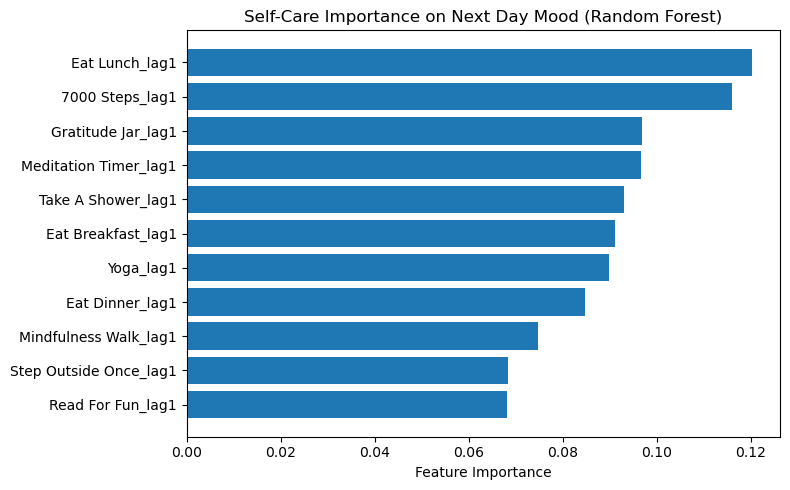

In [134]:
# Plot
plt.figure(figsize=(8, 5))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Self-Care Importance on Next Day Mood (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Feature Selection
* I'm going to go back and reduce features that seem less significant and / or might be highly correlated with other features
* thinking on my selected features, I suspect "Mindfulness Walk" and "Step Outside Once" will be correlated since I usually walk outside!
* Based on the Random Forest model, "Eat Lunch", "7000 Steps", and "Gratitude Jar" are most important
* Based on the Linear Regression model, "Meditation Timer" and "Yoga" are most significant

In [135]:
narrowed_features = [
    '7000 Steps_lag1',
    'Eat Lunch_lag1',
    'Gratitude Jar_lag1',
    'Meditation Timer_lag1',
    'Mindfulness Walk_lag1',
    'Yoga_lag1',
]

#### Linear Regression: Round 2

In [136]:
X_n = df[narrowed_features]
y_n = df['value']
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(X_n, y_n, test_size=0.2, random_state=42)

In [137]:
model_lr_n = LinearRegression()
model_lr_n.fit(X_n_train, y_n_train)

LinearRegression()

In [138]:
y_n_pred = model_lr_n.predict(X_n_test)
print("R² Score:", r2_score(y_n_test, y_n_pred))
print("MSE:", mean_squared_error(y_n_test, y_n_pred))

R² Score: 0.036981345730956794
MSE: 0.2601422714325373


In [139]:
# Pair coefficients with feature names
coeff_lr_n_df = pd.DataFrame({
    'Feature': narrowed_features,
    'Coefficient': model_lr_n.coef_
}).sort_values(by='Coefficient', ascending=False)
coeff_lr_n_df

,Feature,Coefficient
3,Meditation Timer_lag1,0.099354
4,Mindfulness Walk_lag1,0.071603
0,7000 Steps_lag1,0.054374
2,Gratitude Jar_lag1,-0.008587
1,Eat Lunch_lag1,-0.028858
5,Yoga_lag1,-0.055215


In [140]:
X_with_const_lr_n = sm.add_constant(X_n)  # adds intercept term, i.e. baseline mood when I didn’t do any of the activities that day
model_lr_n_sm = sm.OLS(y_n, X_with_const_lr_n).fit()

In [142]:
model_lr_n_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.918
Date:                Mon, 21 Apr 2025   Prob (F-statistic):            0.00803
Time:                        17:11:36   Log-Likelihood:                -647.90
No. Observations:                 833   AIC:                             1310.
Df Residuals:                     826   BIC:                             1343.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.5460      0.040     87.566      0.000       3.467       3.625
7000 Steps_lag1           0.0474      0.041      1.158      0.247      -0.033       0.128
Eat Lunch_lag1           -0.0032      0.042     -0.077      0.939      -0.086       0.080
Gratitude Jar_lag1        0.0272      0.075      0.363      0.716      -0.120       0.174
Meditation Timer_lag1     0.1180      0.039      2.990      0.003       0.041       0.195
Mindfulness Walk_lag1     0.1019      0.045      2.275      0.023       0.014       0.190
Yoga_lag1                -0.0968      0.047     -2.077      0.038      -0.188      -0.005
==============================================================================
Omnibus:                      231.213   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              631.827
Skew:                          -1.403   Prob(JB):                    6.32e-138
Kurtosis:                       6.215   Cond. No.                         6.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### RNN (Recurrent Neural Network) , for fun!

In [59]:
exvar_encoded_df.index.name = 'Record_Date'
exvar_encoded_df = exvar_encoded_df.reset_index()
exvar_encoded_df.head()

,Record_Date,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation Timer,Mindfulness Walk,Read For Fun,Step Outside Once,...,Eat Dinner_lag1,Eat Breakfast_lag1,Eat Lunch_lag1,Gratitude Jar_lag1,Meditation Timer_lag1,Mindfulness Walk_lag1,Read For Fun_lag1,Step Outside Once_lag1,Take A Shower_lag1,Yoga_lag1
0,2022-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
avg_feelings_df = avg_feelings_df.reset_index()
avg_feelings_df.head()

,Record_Date,value
0,2022-10-28,3.125000
1,2022-10-29,3.375000
2,2022-10-30,3.571429
3,2022-10-31,3.200000
4,2022-11-01,3.428571


In [61]:
# Merge on date
df = pd.merge(avg_feelings_df, exvar_encoded_df, on='Record_Date', how='inner')
df = df.sort_values('Record_Date').reset_index(drop=True)

In [62]:
df = df.rename(columns={'value': 'mood'})
df['Meditation Timer'] = pd.to_numeric(df['Meditation Timer'], errors='coerce')

In [63]:
df.dtypes

Record_Date               datetime64[ns]
mood                             float64
7000 Steps                       float64
Eat Dinner                       float64
Eat Breakfast                    float64
Eat Lunch                        float64
Gratitude Jar                    float64
Meditation Timer                 float64
Mindfulness Walk                 float64
Read For Fun                     float64
Step Outside Once                float64
Take A Shower                    float64
Yoga                             float64
7000 Steps_lag1                  float64
Eat Dinner_lag1                  float64
Eat Breakfast_lag1               float64
Eat Lunch_lag1                   float64
Gratitude Jar_lag1               float64
Meditation Timer_lag1            float64
Mindfulness Walk_lag1            float64
Read For Fun_lag1                float64
Step Outside Once_lag1           float64
Take A Shower_lag1               float64
Yoga_lag1                        float64
dtype: object

In [64]:
SEQUENCE_LENGTH = 7  # Past 7 days

features = ['mood', 'Meditation Timer']
X, y = [], []

for i in range(len(df) - SEQUENCE_LENGTH):
    sequence = df.loc[i:i+SEQUENCE_LENGTH-1, features].values
    target = df.loc[i+SEQUENCE_LENGTH, 'mood']
    
    if not np.isnan(sequence).any() and not np.isnan(target):  # drop NaNs
        X.append(sequence)
        y.append(target)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, 7, 2)
print("y shape:", y.shape)  # (samples,)

X shape: (673, 7, 2)
y shape: (673,)


In [65]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# X: shape (samples, time_steps, features)
# y: shape (samples,)
model = Sequential()
model.add(SimpleRNN(32, input_shape=(7, 2), activation='tanh'))  # 7 days, 2 features (mood, meditation)
model.add(Dense(1))  # Output: predicted mood
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20


C:\Users\kaley\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 14.4976 - val_loss: 2.3193
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5293 - val_loss: 0.3071
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2848 - val_loss: 0.3112
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2864 - val_loss: 0.2959
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2435 - val_loss: 0.2875
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2488 - val_loss: 0.2836
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2508 - val_loss: 0.2786
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2560 - val_loss: 0.2813
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2703 - val_loss: 0.2712
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2970 - val_loss: 0.2693
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2827 - val_loss: 0.2708
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2888 - val_loss: 0.270

In [66]:
# baseline model with mood only (no meditation)
features = ['mood']
X2, y2 = [], []

for i in range(len(df) - SEQUENCE_LENGTH):
    sequence = df.loc[i:i+SEQUENCE_LENGTH-1, features].values
    target = df.loc[i+SEQUENCE_LENGTH, 'mood']
    
    if not np.isnan(sequence).any() and not np.isnan(target):  # drop NaNs
        X2.append(sequence)
        y2.append(target)

X2 = np.array(X2)
y2 = np.array(y2)

print("X shape:", X2.shape)  # (samples, 7, 2)
print("y shape:", y2.shape)  # (samples,)

X shape: (737, 7, 1)
y shape: (737,)


In [67]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(7, 2), activation='tanh'))  # 7 days, 2 features (mood, meditation)
model.add(Dense(1))  # Output: predicted mood
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20


C:\Users\kaley\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.2472 - val_loss: 0.2549
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2911 - val_loss: 0.2776
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2334 - val_loss: 0.2453
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2378 - val_loss: 0.2459
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2546 - val_loss: 0.2482
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2678 - val_loss: 0.2411
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2382 - val_loss: 0.2390
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2457 - val_loss: 0.2413
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2539 - val_loss: 0.2442
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2329 - val_loss: 0.2377
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2508 - val_loss: 0.2468
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2449 - val_loss: 0.2487

#### thoughts
* mood-only model performs almost the same, so meditation might not be adding much predictive value.